# Implémentez un modèle de scoring

- **Projet 7 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Étape 2 : Modélisation


## 1.1 Compréhension du problème

### 1.1.1 Problématique

La société financière, nommée **"Prêt à dépenser"**, propose des crédits à la consommation pour des
personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre **un outil de “scoring crédit”** pour calculer la qu’un client
rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc
développer **un algorithme de classification** en s’appuyant sur des sources de données variées (données
comportementales, données provenant d'autres institutions financières, etc.).

### 1.1.2 Les données

Voici [les données](https://www.kaggle.com/c/home-credit-default-risk/data) pour réaliser le
dashboard. Pour plus de simplicité, vous pouvez les télécharger à
[cette adresse](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip).

### 1.1.1 Mission

- Sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring.
- Analyser ce kernel et l’adapter aux besoins de votre mission.

Focalise sur :

1. La construction d'un **modèle de scoring** qui donnera une prédiction sur la probabilité de faillite
   d'un client de façon automatique.
   - élaboration
   - optimisation
   - comprehension (interpretabilité)
2. Construction d'un **dashboard interactif** qui montre avec transparence les décisions d’octroi de
   crédit, à destination des gestionnaires de la relation client permettant d'interpréter les
   prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation
   client.


## 1.2 Definition de l'environnement

- `local` : Développement local (avec échantillon de 50 Mo de données)
- `colab` : Google Colab
- `kaggle` : Kaggle Kernel


In [1]:
ENV = 'local'

if ENV == 'local':
    # local development
    DATA_FOLDER = '../data/raw'
    OUT_FOLDER = '../data/out'
    IMAGE_FOLDER = '../images/modelisation'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC7'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC7'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC7/modelisation'


## 1.3 Fichiers de données

1. Les données en format CSV (>700Mb compactés) sont à télecharger de ce lien:

- https://www.kaggle.com/c/home-credit-default-risk/data
- Pour plus de simplicité, vous pouvez les télécharger à [cette adresse.](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

2.  Placer le fichier compacté (**.zip**) dans le **DATA_FOLDER** défini ci-dessous


### Noms des fichiers de données (identique pour nettoyage et l'analyse exploratoire)

- Le grand fichier zip des données doit être placé dans `DATA_FOLDER` au préalable
- Tous les autres fichiers de données sont téléchargés ou crées pendant le nettoyage, puis enregistrés dans `OUT_FOLDER`


In [2]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Projet+Mise+en+prod+-+home-credit-default-risk.zip'
RAW_DATA_FILENAME = 'HomeCredit_columns_description.csv'
SAMPLE_DATA_FILENAME = 'HomeCredit_columns_description.csv'


# Données nettoyés (OUT_FOLDER)
CLEAN_DATA_FILENAME = 'cleaned_data_scoring.csv'
CLEAN_DATA_SAMPLE = 'cleaned_data_sample.csv'  # 100,000 registres
CLEAN_DATA_FEATURES = 'cleaned_data_features.csv'  # 100 meilleur features
SAMPLE_SIZE = 10000


## 1.4 Requirements: Bibliothèques utilisées dans ce notebook

Ce notebook marche a été testé en developpement local, sur Google Colab et Kaggle

```txt
# copy dans un fichier requirements.txt, puis
# !pip install -r requirements.txt
```


In [3]:
# Decommentarise la ligne suivant si vous ne voulez pas changer vos versions existants
# !pip install numpy pandas matplotlib seaborn scipy sklearn missingno requests


In [4]:
# import local functions
import outils_io
outils_io.install_libraries({'numpy', 'pandas', 'matplotlib',
                             'seaborn', 'sklearn'})


required modules: ['pandas', 'seaborn', 'matplotlib', 'sklearn', 'numpy']
missing modules: []


## 1.5 Import dependencies


### 1.5.1 Import des bibliothèques utilisées par ce notebook


In [5]:
# suppress furture warnings de pandas 1.3.0
from contextlib import contextmanager
import time
import gc
import os
import warnings
import platform
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# feature preprocessing
from sklearn import impute
from sklearn import preprocessing

# feature et parameter selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Sampling (SMOTE : Synthetic Minority Oversampling TEchnique)
import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek


### 1.5.2 Liste des versions des bibliothèques utilisées


In [7]:
print(f'python version = {platform.python_version()}')
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


python version = 3.7.0
versions des bibliothèques utilisées:
platform==1.0.8; sklearn==1.0.2; seaborn==0.11.2; pandas==1.1.5; numpy==1.21.5; imblearn==0.9.0


### 1.5.3 Configuration défauts d'affichage


In [8]:
from sklearn import set_config
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 20 lignes
pd.set_option('display.max_colwidth', 800)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab10")

set_config(display='diagram')
# displays HTML representation in a jupyter context


### Bibliothèque personelle

On utilise un nom non standard


In [9]:
import outils_io
import outils_preprocess
import outils_stats
import outils_timed
import outils_vis

# frequently used functions
from outils_vis import to_png
from outils_timed import timer


### Configuration personelle


In [10]:

# Enregistre parametres globals dans outils
outils_vis.set_option('IMAGE_FOLDER', IMAGE_FOLDER)
outils_vis.set_option('SAVE_IMAGES', True)

if ENV != 'kaggle':
    outils_io.os_make_dir(DATA_FOLDER)
    outils_io.os_make_dir(OUT_FOLDER)

outils_io.os_make_dir(IMAGE_FOLDER)


## Fonctions utilitaires


### Test si un séries est log scale

- utilisé pour l'échelle des validation curves des hyperparamètres


In [11]:
# import numpy as np
def is_log_scale(series):
    """Test si series est log scale"""
    try:
        if isinstance(series, pd.Series):
            series = series.values
        # suppose les valeurs au fin sont plus grand
        dif1 = series[-1] / series[-2]
        dif2 = series[-2] / series[-3]
        return round(dif1/dif2, 2) == 1.
    except:
        return False


print(is_log_scale([0, 1]))
print(is_log_scale(range(1, 10)))
print(is_log_scale(np.logspace(2, 8, 10)))


False
False
True


# Import des données nettoyés


In [12]:
# Set SAMPLE=True for Rapid Development
SAMPLE = True

full_data_path = f'{OUT_FOLDER}/{CLEAN_DATA_FILENAME}'  # > 700 variables
best_data_path = f'{OUT_FOLDER}/{CLEAN_DATA_FEATURES}'  # les top 100 features
# echantillon pour developpement rapide
sample_data_path = f'{OUT_FOLDER}/{CLEAN_DATA_SAMPLE}'

cleaned_data_path = sample_data_path if SAMPLE else best_data_path
with timer('Load cleaned data'):
    df_data = pd.read_csv(cleaned_data_path)


Load cleaned data - done in 0s


In [13]:
with timer('Reduce memory'):
    df_data = outils_preprocess.reduce_memory(df_data)


Initial df memory usage is 6.49 MB for 85 columns
Final memory usage is: 1.88 MB - decreased by 71.0%
Reduce memory - done in 0s


## Create X (fields), y (target)


In [14]:
def create_X_y(df: pd.DataFrame):
    target = df['TARGET'].copy()
    fields = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    return fields, target


X, y = create_X_y(df_data)


In [15]:
TARGET_CLASSES = ['0=repaid', '1=not repaid']
le = preprocessing.LabelEncoder()
target_classes = le.fit_transform(TARGET_CLASSES)
print(target_classes)


[0 1]


### Split train / test


In [16]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2)


## Preprocessing de données

On crée un preprocessor pour pouvoir ajuster les paramètres de preprocessing


In [17]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

category_features = cat_selector(x_train)
numerical_features = num_selector(x_train)
target_features = y_train.name

print(f'numerical_features : {len(numerical_features)}')
print(f'category_features : {len(category_features)}')
print(f'target_features : {target_features}')


numerical_features : 83
category_features : 0
target_features : TARGET


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


def create_preprocessor(num_cols=num_selector, cat_cols=cat_selector):
    """Preprocessor """
    num_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoding', OneHotEncoder(dtype=int, sparse=True, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
        remainder='passthrough')
    return preprocessor


preprocessor = create_preprocessor()
preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001FCECC05048>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoding',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001FCECC05080>)])

In [19]:
numeric_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('simple_scale', StandardScaler())
        ]), num_selector),
    ]))
])
numeric_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('simple_scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FCECC05048>)]))])

In [20]:
numeric_pipeline.fit(x_train)
print(numeric_pipeline.feature_names_in_[:5])

# Erreur si on essaie de récuperer les noms de colonnes
# numeric_pipeline.get_feature_names_out(numeric_pipeline.feature_names_in_)


['EXT_SOURCE_3' 'EXT_SOURCE_2' 'EXT_SOURCE_1' 'PREV_DAYS_DECISION_MIN'
 'PREV_AMT_ANNUITY_MEAN']


### Get feature names pour les preprocessors

Pour interpreter les models, il faut savoir les variables après preprocessing.

Malheureusement, beaucoup des transformers de `sklearn` perd leurs feature names

- SimpleImputer, FunctionTransformer, StandardScalar do not implement `get_feature_names_out`
- Ça pose des problèmes pour l'interprétabilité des modèles

L'ordre des features dépend des column selectors et l'ordre des ColumnTransformers

- Avec des 'named transformers' et 'named steps' dans un ordre spécifique, on peut récupérer les noms des features dans l'ordre


In [21]:
def get_features_out(pipe, xtrain_):
    """
    Get column names after preprocessing

    assumes (requires preprocessors with following structure):
    - all named transformers, if present, are in same order as listed below
    - if preprocessor has other transformers, add to list below
    - only final transformer (named 'cat') adds columns, via an encoder step named 'ohe'
    - if imputer is used, it does not add indicator columns
    """

    def get_features_in_(trans: ColumnTransformer, name=None):
        try:
            features = list(trans.named_transformers_[name].feature_names_in_)
        except:
            # named transformer doesn't exist in pipeline, return empty list
            features = []
        return features

    pipe.fit(xtrain_)
    if hasattr(pipe, 'named_steps'):
        trans: ColumnTransformer = pipe.named_steps['preprocessor']
    else:
        trans = pipe
    # SimpleImputer, FunctionTransformer, StandardScalar do not implement get_feature_names_out

    # Get feature names of numeric columns
    num_features = get_features_in_(trans, 'num')
    scale_features = get_features_in_(trans, 'simple_scale')
    log_features = get_features_in_(trans, 'log_scale')
    ordinal_features = get_features_in_(trans, 'ordinal')
    try:
        cat_encoder = trans.named_transformers_['cat']
        ohe = cat_encoder.named_steps['ohe']
        category_features = list(
            ohe.get_feature_names_out(cat_encoder.feature_names_in_))
    except:
        category_features = []
    features_out = (num_features+scale_features + log_features
                    + ordinal_features + category_features)
    return features_out


Test get_features_out


In [22]:
x_transformed = numeric_pipeline.fit_transform(x_train)
x_transformed_columns = get_features_out(numeric_pipeline, x_train)
print(x_transformed.shape)
print(len(x_transformed_columns))
print(x_transformed_columns[:3])


(8000, 83)
83
['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']


#### Preprocessor avec feature names


In [23]:
def preprocess(pipe, x_train_, x_test_):
    """Preprocess x_train et x_test séparament.
    Retourner les données transformés comme pandas DataFrames avec feature names"""
    features_out = get_features_out(pipe, x_train_)
    x_train_out = pd.DataFrame(pipe.fit_transform(
        x_train_), columns=features_out, index=x_train_.index)
    x_test_out = pd.DataFrame(pipe.transform(
        x_test_), columns=features_out, index=x_test_.index)
    return x_train_out, x_test_out


### Impute NaN avant oversampling

Pour oversampling, il ne faut pas avoir des NaN

On les remplis avec SimpleImputer (median), puis un rescale


In [24]:
with timer('preprocess data'):
    x_train_prep, x_test_prep = preprocess(preprocessor, x_train, x_test)


preprocess data - done in 0s


## Options de sampling : Ré-equilibration des classes cible

Il y a environ 800 colonnes de données, la plupart seront insignifiant en importance pour la modèle.

On peut faire feature selection basé sur les données, mais comme les données sont pour la plupart target = 0, ça met plus de poid sur la classe 'loan repaid.

La référence ci-dessous recommande faire la ré-equilibration des classes, via oversampling AVANT feature selection.

#### Références

- [SMOTE for high-dimensional class-imbalanced data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/)


### Oversample les données sans valeurs manquantes (NaN)


On a plusieurs stratégies de sampling possible pour équilibré le poid des classes

**Weights**

- ajout plus de poids pour les observations minoritaires

**Random undersampling**

- éliminaire aléatoirement des observations majoritaires

**Random oversampling**

- ajout aleatoirement aux données des copies d'observations minoritaires

**Synthetic Minority Oversampling Technique (SMOTE)**

- ajout des observations minoritaires similaires mais distinctes des observations minoritaires existantes

**SMOTE Tomek**

- oversample, puis undersample les bordeline cas


# Créer des instances des samplers


In [25]:
# Random undersampling
undersampler = RandomUnderSampler(sampling_strategy='majority')

# Random oversampling
oversampler = RandomOverSampler(sampling_strategy='minority')

# Synthetic Minority Oversampling Technique (SMOTE)
smote_adasyn = SMOTE(sampling_strategy='ADASYN')

# over-sample borderline, then undersample)
smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))


In [26]:
from imblearn import over_sampling

oversampler = over_sampling.SMOTE()
with timer(title='oversample'):
    x_train_smote, y_train_smote = oversampler.fit_resample(
        x_train_prep, y_train)


print(X.shape)
print(x_train.shape)
print(x_train_smote.shape)


oversample - done in 0s
(10000, 83)
(8000, 83)
(14676, 83)


In [27]:

undersampler = RandomUnderSampler(sampling_strategy='majority')
oversampler = RandomOverSampler(sampling_strategy='minority')

# SMOTE :
# oversample with ADASYN
smote_adasyn = SMOTE(sampling_strategy='ADASYN')


# over-sample borderline, then undersample)
smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))


## Construction d'un model pipeline avec SMOTE

References

- <https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7>


In [28]:
from imblearn import pipeline as imbpipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
# from sklearn.svm import LinearSVC
# test model pipeline avec un classifier rapide
from sklearn.linear_model import RidgeClassifier


def create_model(
    sampler=SMOTE(random_state=11),
    preprocessor=numeric_pipeline,
    feature_selector=SelectKBest(score_func=f_classif, k=50),
    classifier=RidgeClassifier()
):
    model = imbpipeline.Pipeline(steps=[
        ('smote', sampler),
        ('preprocess', preprocessor),
        ('feat_select', feature_selector),
        ('clf', classifier)
    ])
    # ('feat_select', SelectFromModel(LGBMClassifier, max_features=100)),
    return model


test_model = create_model(preprocessor=preprocessor)
test_model


Pipeline(steps=[('smote', SMOTE(random_state=11)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FCECC05048>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FCECC05080>)])),
                ('feat_select', SelectKBest(k=50)),
                ('clf', RidgeClassifier())])

In [29]:


stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)


param_grid = {'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=test_model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           verbose=2,
                           return_train_score=True,
                           n_jobs=-1)


grid_search.fit(x_train_prep, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(x_test_prep, y_test)
# return {'cv_score':cv_score, 'test_score':test_score}


Fitting 5 folds for each of 7 candidates, totalling 35 fits


# Les métriques d'évaluation

Pour la classification binaire, les métriques pour estimer les erreurs entre y_pred et y_test sont :

**ROC AUC (Area Under the Curve)**

- peut être comparé entre modèles

**log loss**

- logistic loss or cross-entropy loss. Normalement utilisé s'il y a plus de 2 classes dans TARGET

**precision**
Quelle portion du target prédit sont du vrai classe ?

- precision = TP / (TP + FP)

**recall**
Quelle portion du vrai classe sont présent dans le classe prédit ?

- recall = TP / (TP + FN)

**F1-score**
Accuracy équilibré

- F1 = 2 _ (precision _ recall) / (precision + recall)
- F1 = (2 _ TP) / (2 _ TP + FP + FN)

**Fbeta-score**
Generalisation de F1-score pour mettre plus de poids sur precision (ex beta=0.5), ou pour mettre plus de poid sur recall (ex: beta=2)


### Custom Credit Scorer

Pour la banque, le cout d'un faux positif (donner un prêt à un mauvais payeur) est plus que le cout d'un faux negatif (refuser un prêt à un bon client)

Donc, il faut penaliser les faux positif plus que les faux negatif


In [30]:
def custom_credit_score(y_test, y_pred):
    """
    Penalise les prêts qui ne sont pas repayés (perte plus importante que si on ne prend pas un client bon)
    (TN - FP - 3*FN)
    """
    cm = metrics.confusion_matrix(y_test, y_pred)
    # y_true=0 (bon), y_pred=0 (bon) - ce que le banque veut donner un pret
    TN = cm[0, 0]
    # y_true=1 (mauvais), y_pred=1 (bon) - grand perte pour la banque
    FN = cm[1, 0]
    # y_true=0 (bon), y_pred=1 (mauvais) - petit perte (manque de preter à un bon client
    FP = cm[0, 1]
    # y_true=1 (mauvais), y_pred=1 (mauvais) - ce que la banque veut refuser
    TP = cm[1, 1]
    # bank_profit = TN * valeur_par_pret_fait
    # bank_loss = FN * grand_pert_mauvais_pret + FP * valeur_par_pret_perdu
    # bank_net_profit = bank_profit - bank loss
    # bank_net_profit = (TN - FP) * valeur_par_pret - FN * grand_pert_mauvais_pret
    # normalise par la taille de l'echantillon (cm.sum())
    valeur_par_pret = 1  # suppose la valeur des prêts fait ou perdus sont identiques
    # (on suppose que la cout d'un mauvais prêt et 3 fois le rentabilité d'un bon prêt)
    grand_pert_mauvais_pret = 3
    profit_score = (TN - FP - 3*FN)/cm.sum()
    return profit_score


In [31]:
from sklearn import metrics

# mise en constant pour référence ailleurs
ROC_AUC = 'roc_auc'
CV_SCORING = ''


def performance_metrics(y_true_, y_pred_):
    """Plusieurs functions de cout (Loss)"""
    loss = dict(
        roc_auc=metrics.roc_auc_score(y_true_, y_pred_),
        logloss=metrics.log_loss(y_true_, y_pred_),
        precision=metrics.precision_score(y_true_, y_pred_),
        recall=metrics.recall_score(y_true_, y_pred_),
        f1=metrics.f1_score(y_true_, y_pred_),
        f2=metrics.fbeta_score(y_true_, y_pred_, beta=2),
        f05=metrics.fbeta_score(y_true_, y_pred_, beta=0.5),
        custom_score=custom_credit_score(y_true_, y_pred_),
    )
    for metric in loss.keys():
        loss[metric] = round(loss[metric], 3)
    return loss


y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 1, 0, 1]
print(metrics.confusion_matrix(y_true1, y_pred1))
print(performance_metrics(y_true1, y_pred1))


[[1 1]
 [1 1]]
{'roc_auc': 0.5, 'logloss': 17.27, 'precision': 0.5, 'recall': 0.5, 'f1': 0.5, 'f2': 0.5, 'f05': 0.5, 'custom_score': -0.75}


### Accumulation des performances des modèles


In [32]:
df_resultats = pd.DataFrame()


def add_model_score(df: pd.DataFrame = None, model_name: str = 'none', ARI: float = 0, k: int = 0, **kwargs):
    global df_resultats
    if df is None:
        df = df_resultats
    """ajout les resultats d'un model """
    resultats = dict(model=model_name)
    resultats = dict(**resultats, **kwargs)
    df = df.append(resultats, ignore_index=True)
    return df


# test
add_model_score(pd.DataFrame(), optimizer='adam', k=7)


,model,optimizer
0,none,adam


## Teste des métriques de performance


In [33]:
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 0, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_test = add_model_score(pd.DataFrame(), 'perfect', **perf)
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 1, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_test = add_model_score(df_test, '1-each (TN,FN,FP,TP)', **perf)
y_true1 = [1, 1, 0, 1]
y_pred1 = [0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_test = add_model_score(df_test, 'a few bad payers', **perf)
y_true1 = [1, 1, 1, 1, 0, 1]
y_pred1 = [0, 0, 0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_test = add_model_score(df_test, 'many bad payers', **perf)
y_true1 = [0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_test = add_model_score(df_test, 'a few wrong refusals', **perf)
y_true1 = [0, 0, 0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_test = add_model_score(df_test, 'many wrong refusals', **perf)
df_test.sort_values(by='custom_score')


,custom_score,f05,f1,f2,logloss,model,precision,recall,roc_auc
3,-1.833,0.556,0.333,0.238,23.026,many bad payers,1.000,0.200,0.600
2,-1.250,0.714,0.500,0.385,17.269,a few bad payers,1.000,0.333,0.667
1,-0.750,0.500,0.500,0.500,17.270,"1-each (TN,FN,FP,TP)",0.500,0.500,0.500
5,-0.500,0.238,0.333,0.556,23.026,many wrong refusals,0.200,1.000,0.600
4,-0.250,0.385,0.500,0.714,17.270,a few wrong refusals,0.333,1.000,0.667
0,0.500,1.000,1.000,1.000,0.000,perfect,1.000,1.000,1.000


On voit qu'on peut utiliser F2-score, par exemple, au lieu de custom scorer

On essaie d'optimiser roc_auc, en suivant custom_score et f2_score


In [34]:
custom_scorer = metrics.make_scorer(
    custom_credit_score, greater_is_better=True)
f2_scorer = metrics.make_scorer(
    metrics.fbeta_score, greater_is_better=True, beta=2)

# GridsearchCV attend un dictionnaire si on fourni plusieurs scorers
CV_SCORERS = {
    'roc_auc': 'roc_auc',
    'custom_scorer': custom_scorer,
    'f2_scorer': f2_scorer
}


In [35]:
# Test GridSearch
grid_search = GridSearchCV(estimator=test_model,
                           param_grid=param_grid,
                           scoring=CV_SCORERS,
                           refit='roc_auc',
                           cv=stratified_kfold,
                           verbose=2,
                           return_train_score=True,
                           n_jobs=-1)


grid_search.fit(x_train_prep, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(x_test_prep, y_test)
df_cv = pd.DataFrame(grid_search.cv_results_)
df_cv.head()


Fitting 5 folds for each of 7 candidates, totalling 35 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,split0_test_custom_scorer,split1_test_custom_scorer,split2_test_custom_scorer,split3_test_custom_scorer,split4_test_custom_scorer,mean_test_custom_scorer,std_test_custom_scorer,rank_test_custom_scorer,split0_train_custom_scorer,split1_train_custom_scorer,split2_train_custom_scorer,split3_train_custom_scorer,split4_train_custom_scorer,mean_train_custom_scorer,std_train_custom_scorer,split0_test_f2_scorer,split1_test_f2_scorer,split2_test_f2_scorer,split3_test_f2_scorer,split4_test_f2_scorer,mean_test_f2_scorer,std_test_f2_scorer,rank_test_f2_scorer,split0_train_f2_scorer,split1_train_f2_scorer,split2_train_f2_scorer,split3_train_f2_scorer,split4_train_f2_scorer,mean_train_f2_scorer,std_train_f2_scorer
0,0.477881,0.032028,0.043139,0.001302,0.001,{'clf__alpha': 0.001},0.785324,0.725265,0.753391,0.724767,0.708627,0.739475,0.027076,7,0.753633,0.773926,0.761017,0.765036,0.768435,0.764409,0.006853,0.298125,0.280625,0.283125,0.28125,0.31625,0.291875,0.013778,3,0.294687,0.336094,0.301719,0.317500,0.305937,0.311188,0.014489,0.454120,0.403992,0.427230,0.407197,0.40275,0.419058,0.019645,3,0.434270,0.454876,0.437515,0.438343,0.434471,0.439895,0.007663
1,0.485082,0.014460,0.042177,0.003059,0.01,{'clf__alpha': 0.01},0.785324,0.725265,0.753391,0.724767,0.708633,0.739476,0.027075,6,0.753633,0.773926,0.761017,0.765035,0.768435,0.764409,0.006853,0.298125,0.280625,0.283125,0.28125,0.31625,0.291875,0.013778,3,0.294687,0.336094,0.301719,0.317500,0.305937,0.311188,0.014489,0.454120,0.403992,0.427230,0.407197,0.40275,0.419058,0.019645,3,0.434270,0.454876,0.437515,0.438343,0.434471,0.439895,0.007663
2,0.539701,0.023112,0.045232,0.003087,0.1,{'clf__alpha': 0.1},0.785324,0.725265,0.753401,0.724767,0.708627,0.739477,0.027077,5,0.753634,0.773926,0.761017,0.765034,0.768435,0.764409,0.006852,0.298125,0.280625,0.283125,0.28125,0.31625,0.291875,0.013778,3,0.294687,0.336094,0.301719,0.317500,0.305937,0.311188,0.014489,0.454120,0.403992,0.427230,0.407197,0.40275,0.419058,0.019645,3,0.434270,0.454876,0.437515,0.438343,0.434471,0.439895,0.007663
3,0.528576,0.022351,0.058293,0.010344,1,{'clf__alpha': 1},0.785340,0.725281,0.753385,0.724777,0.708633,0.739483,0.027077,4,0.753637,0.773925,0.761016,0.765037,0.768437,0.764410,0.006852,0.298125,0.280625,0.283125,0.28125,0.31625,0.291875,0.013778,3,0.295000,0.336094,0.302031,0.317188,0.305937,0.311250,0.014351,0.454120,0.403992,0.427230,0.407197,0.40275,0.419058,0.019645,3,0.434372,0.454876,0.437619,0.438237,0.434471,0.439915,0.007646
4,0.572098,0.091325,0.055110,0.014502,10,{'clf__alpha': 10},0.785386,0.725317,0.753427,0.724823,0.708720,0.739535,0.027068,3,0.753632,0.773916,0.760996,0.765026,0.768450,0.764404,0.006854,0.299375,0.280625,0.284375,0.28125,0.31625,0.292375,0.013747,2,0.295469,0.336094,0.302031,0.317031,0.305625,0.311250,0.014257,0.454545,0.403992,0.427632,0.407197,0.40275,0.419223,0.019831,2,0.435450,0.454876,0.437619,0.437244,0.434368,0.439911,0.007576


## Cross-validation parameter selection

- il faut valider les paramètres sélectionnés pendant grid search

### Validation curves (pour sélection d'hyperparamètres)


In [36]:
def plot_best_param_scores(gs, param='alpha', model_name='', score='roc_auc', logx=False):
    cv = pd.DataFrame.from_dict(gs.cv_results_)
    param_key = f'param_{param}'
    if not param_key in cv.columns:
        return f'{param_key} not in cross-validation results'

    # filter by all best params, except chosen param
    filtre = cv.index == cv.index
    best_param = gs.best_params_[param]
    if not isinstance(best_param, (int, float)):
        return 'param is not a number'
    for key in gs.best_params_.keys():
        # print(f'key={key}, param_key={param_key}')
        if key != param:
            filtre &= cv[f'param_{key}'] == gs.best_params_[key]

    res = cv[filtre]
    if len(res) < 3:
        print('filter < 3 results')
        return res

    if f'mean_train_{score}' in res.columns:
        plt.errorbar(x=res[param_key], y=res[f'mean_train_{score}'],
                     yerr=res[f'std_train_{score}'], label='cv train')
    plt.errorbar(x=res[param_key], y=res[f'mean_test_{score}'],
                 yerr=res[f'std_test_{score}'], label='cv test')
    ax = plt.gca()

    y_min, y_max = plt.ylim()
    ax.vlines(best_param, y_min, y_max,
              label=f'best value : {param} = {best_param:.3f}', linestyle="--", color="tab:orange")
    plt.legend(loc='best')
    plt.xlabel(f'paramètre : {param}')
    if is_log_scale(res[param_key].values) or logx:
        plt.xscale('log')
    plt.ylabel(f'score ({score})')
    plt.suptitle(f'{model_name}')
    plt.title(f'Validation Curve (paramètre : {param})')
    to_png(f'{model_name} - Validation Curve (paramètre : {param})')
    plt.show()


In [37]:
# Test
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier

param_grid = {
    # 'fit_intercept': [True, False],
    # 'clf__class_weight': [None, 'balanced'],
    'clf__alpha': np.logspace(-3, 5, 20)
},

gs = GridSearchCV(test_model,
                  param_grid=param_grid,
                  return_train_score=True,
                  scoring=CV_SCORERS,
                  refit='roc_auc')


gs.fit(x_train_prep, y_train)
gs.score(x_test_prep, y_test)
cv = pd.DataFrame.from_dict(gs.cv_results_)
cv.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,split0_test_custom_scorer,split1_test_custom_scorer,split2_test_custom_scorer,split3_test_custom_scorer,split4_test_custom_scorer,mean_test_custom_scorer,std_test_custom_scorer,rank_test_custom_scorer,split0_train_custom_scorer,split1_train_custom_scorer,split2_train_custom_scorer,split3_train_custom_scorer,split4_train_custom_scorer,mean_train_custom_scorer,std_train_custom_scorer,split0_test_f2_scorer,split1_test_f2_scorer,split2_test_f2_scorer,split3_test_f2_scorer,split4_test_f2_scorer,mean_test_f2_scorer,std_test_f2_scorer,rank_test_f2_scorer,split0_train_f2_scorer,split1_train_f2_scorer,split2_train_f2_scorer,split3_train_f2_scorer,split4_train_f2_scorer,mean_train_f2_scorer,std_train_f2_scorer
0,0.269179,0.023697,0.020995,0.000597,0.001,{'clf__alpha': 0.001},0.770255,0.743921,0.710583,0.748466,0.716879,0.738021,0.02183,11,0.759389,0.768130,0.773944,0.761432,0.767743,0.766128,0.005199,0.305625,0.294375,0.276875,0.299375,0.309375,0.297125,0.011358,5,0.315625,0.311094,0.325469,0.308281,0.315781,0.31525,0.005843,0.456685,0.41587,0.38756,0.409047,0.404483,0.414729,0.022965,5,0.4375,0.444365,0.449289,0.438052,0.444311,0.442704,0.004414
1,0.238496,0.009822,0.018174,0.000811,0.00263665,{'clf__alpha': 0.0026366508987303583},0.770255,0.743921,0.710583,0.748466,0.716879,0.738021,0.02183,11,0.759388,0.768130,0.773944,0.761433,0.767743,0.766128,0.005200,0.305625,0.294375,0.276875,0.299375,0.309375,0.297125,0.011358,5,0.315625,0.311094,0.325469,0.308281,0.315781,0.31525,0.005843,0.456685,0.41587,0.38756,0.409047,0.404483,0.414729,0.022965,5,0.4375,0.444365,0.449289,0.438052,0.444311,0.442704,0.004414
2,0.268192,0.028210,0.022385,0.007531,0.00695193,{'clf__alpha': 0.0069519279617756054},0.770255,0.743921,0.710583,0.748466,0.716879,0.738021,0.02183,11,0.759388,0.768130,0.773944,0.761433,0.767744,0.766128,0.005200,0.305625,0.294375,0.276875,0.299375,0.309375,0.297125,0.011358,5,0.315625,0.311094,0.325469,0.308281,0.315781,0.31525,0.005843,0.456685,0.41587,0.38756,0.409047,0.404483,0.414729,0.022965,5,0.4375,0.444365,0.449289,0.438052,0.444311,0.442704,0.004414
3,0.245698,0.006985,0.019931,0.002148,0.0183298,{'clf__alpha': 0.018329807108324356},0.770255,0.743916,0.710583,0.748466,0.716879,0.738020,0.02183,14,0.759388,0.768130,0.773944,0.761433,0.767744,0.766128,0.005200,0.305625,0.294375,0.276875,0.299375,0.309375,0.297125,0.011358,5,0.315625,0.311094,0.325469,0.308281,0.315781,0.31525,0.005843,0.456685,0.41587,0.38756,0.409047,0.404483,0.414729,0.022965,5,0.4375,0.444365,0.449289,0.438052,0.444311,0.442704,0.004414
4,0.246265,0.012291,0.019982,0.001619,0.0483293,{'clf__alpha': 0.04832930238571752},0.770255,0.743916,0.710583,0.748466,0.716879,0.738020,0.02183,14,0.759388,0.768131,0.773944,0.761433,0.767744,0.766128,0.005200,0.305625,0.294375,0.276875,0.299375,0.309375,0.297125,0.011358,5,0.315625,0.311094,0.325469,0.308281,0.315781,0.31525,0.005843,0.456685,0.41587,0.38756,0.409047,0.404483,0.414729,0.022965,5,0.4375,0.444365,0.449289,0.438052,0.444311,0.442704,0.004414


"RidgeClassifier_-_Validation_Curve_(paramètre_-_clf__alpha).png"


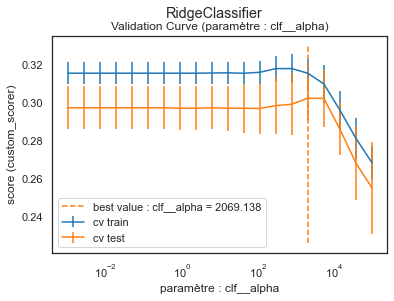

In [38]:
# plot_best_param_scores(gs, param='alpha', score='roc_auc', model_name='RidgeClassifier')
plot_best_param_scores(
    gs, param='clf__alpha', score='custom_scorer', model_name='RidgeClassifier')
